In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
dataset = pd.read_table('Sentiment140.tenPercent.sample.tweets.tsv')

dataset.isnull().values.any()

dataset.shape

(160000, 2)

In [3]:
dataset.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [4]:
dataset["tweet_text"][2]

"@greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him. "

In [6]:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<AxesSubplot:xlabel='sentiment_label', ylabel='count'>

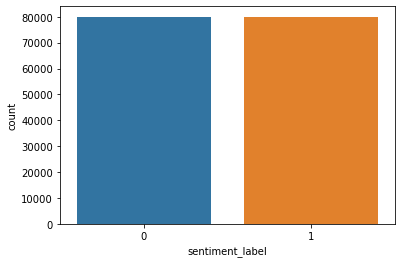

In [7]:
import seaborn as sns

sns.countplot(x='sentiment_label', data=dataset)

In [8]:
dataset


,sentiment_label,tweet_text
0,1,"@elephantbird Hey dear, Happy Friday to You A..."
1,1,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,1,@Covergirl08 I take pride in what I do
159998,1,heading to work on the 6


In [9]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
X = []
sentences = list(dataset['tweet_text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
X[2]

' greeniebach reckon he ll play even if he not but know nothing It won be the same without him '

In [13]:
y = dataset['sentiment_label']

y = np.array(list(map(lambda x: 1 if x==1 else 0, y)))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [15]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [18]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#     #Simple Neural Network

In [20]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          10639000  
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 10,649,001
Trainable params: 10,001
Non-trainable params: 10,639,000
_________________________________________________________________
None


In [22]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
800/800 [==============================] - 7s 8ms/step - loss: 0.6148 - acc: 0.6663 - val_loss: 0.5954 - val_acc: 0.6898
Epoch 2/6
800/800 [==============================] - 7s 9ms/step - loss: 0.5818 - acc: 0.6982 - val_loss: 0.5835 - val_acc: 0.6970
Epoch 3/6
800/800 [==============================] - 6s 8ms/step - loss: 0.5744 - acc: 0.7057 - val_loss: 0.5814 - val_acc: 0.7008
Epoch 4/6
800/800 [==============================] - 7s 9ms/step - loss: 0.5713 - acc: 0.7086 - val_loss: 0.5829 - val_acc: 0.7001
Epoch 5/6
800/800 [==============================] - 7s 8ms/step - loss: 0.5691 - acc: 0.7087 - val_loss: 0.5817 - val_acc: 0.7011
Epoch 6/6
800/800 [==============================] - 7s 8ms/step - loss: 0.5677 - acc: 0.7115 - val_loss: 0.5811 - val_acc: 0.7026


In [23]:
score = model.evaluate(X_test, y_test, verbose=1)

1000/1000 [==============================] - 3s 3ms/step - loss: 0.5814 - acc: 0.7047


In [24]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5813583135604858
Test Accuracy: 0.7046874761581421


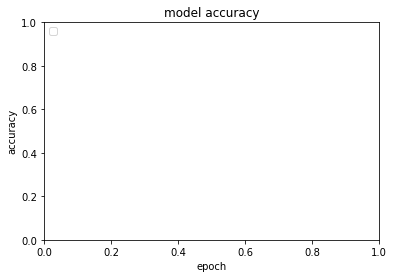

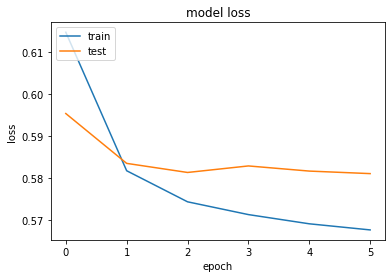

In [25]:
import matplotlib.pyplot as plt

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Convolutional neural network

In [27]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [28]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          10639000  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 10,703,257
Trainable params: 64,257
Non-trainable params: 10,639,000
_________________________________________________________________
None


In [29]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
800/800 [==============================] - 526s 657ms/step - loss: 0.5450 - acc: 0.7201 - val_loss: 0.5210 - val_acc: 0.7410
Epoch 2/6
800/800 [==============================] - 526s 657ms/step - loss: 0.4813 - acc: 0.7682 - val_loss: 0.4947 - val_acc: 0.7621
Epoch 3/6
800/800 [==============================] - 522s 652ms/step - loss: 0.4506 - acc: 0.7879 - val_loss: 0.5188 - val_acc: 0.7507
Epoch 4/6
800/800 [==============================] - 527s 659ms/step - loss: 0.4224 - acc: 0.8061 - val_loss: 0.5020 - val_acc: 0.7580
Epoch 5/6
800/800 [==============================] - 522s 653ms/step - loss: 0.3944 - acc: 0.8224 - val_loss: 0.5001 - val_acc: 0.7632
Epoch 6/6
1000/1000 [==============================] - 75s 75ms/step - loss: 0.5205 - acc: 0.7564


In [30]:
score = model.evaluate(X_test, y_test, verbose=1)

1000/1000 [==============================] - 76s 76ms/step - loss: 0.5205 - acc: 0.7564


In [31]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5205327868461609
Test Accuracy: 0.7564374804496765


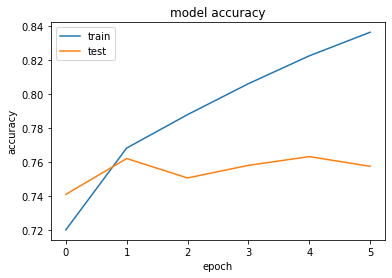

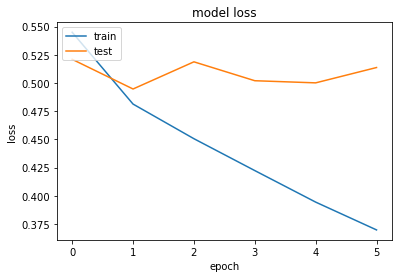

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [49]:
instance = X[100]
print(instance)

at creative moment with katii thinkin about name for our creative work 


In [50]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.3499127]], dtype=float32)